In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sloan-digital-sky-survey-dr16/Skyserver_12_30_2019 4_49_58 PM.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import itertools
import numpy as np
import seaborn as sns

Using TensorFlow backend.


In [3]:
df = pd.read_csv("/kaggle/input/sloan-digital-sky-survey-dr16/Skyserver_12_30_2019 4_49_58 PM.csv")
df.head()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
0,1237666301628060000,47.372545,0.820621,18.69254,17.13867,16.55555,16.34662,16.17639,4849,301,5,771,8168632633242440000,STAR,0.000115,7255,56597,832
1,1237673706652430000,116.303083,42.455980,18.47633,17.30546,17.24116,17.32780,17.37114,6573,301,6,220,9333948945297330000,STAR,-0.000093,8290,57364,868
2,1237671126974140000,172.756623,-8.785698,16.47714,15.31072,15.55971,15.72207,15.82471,5973,301,1,13,3221211255238850000,STAR,0.000165,2861,54583,42
3,1237665441518260000,201.224207,28.771290,18.63561,16.88346,16.09825,15.70987,15.43491,4649,301,3,121,2254061292459420000,GALAXY,0.058155,2002,53471,35
4,1237665441522840000,212.817222,26.625225,18.88325,17.87948,17.47037,17.17441,17.05235,4649,301,3,191,2390305906828010000,GALAXY,0.072210,2123,53793,74


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
objid        100000 non-null int64
ra           100000 non-null float64
dec          100000 non-null float64
u            100000 non-null float64
g            100000 non-null float64
r            100000 non-null float64
i            100000 non-null float64
z            100000 non-null float64
run          100000 non-null int64
rerun        100000 non-null int64
camcol       100000 non-null int64
field        100000 non-null int64
specobjid    100000 non-null uint64
class        100000 non-null object
redshift     100000 non-null float64
plate        100000 non-null int64
mjd          100000 non-null int64
fiberid      100000 non-null int64
dtypes: float64(8), int64(8), object(1), uint64(1)
memory usage: 13.7+ MB


In [5]:
df_new = df.iloc[:, 4:8]
df_new['class'] = df['class']
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
g        100000 non-null float64
r        100000 non-null float64
i        100000 non-null float64
z        100000 non-null float64
class    100000 non-null object
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


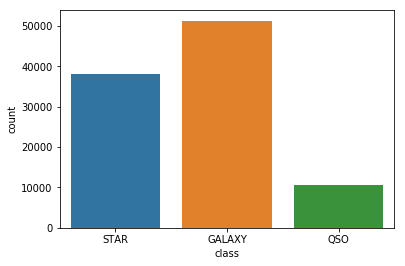

In [6]:
sns.countplot(x= 'class', data = df_new)
plt.show()

In [7]:
#Resampling
star = df_new[df_new['class'] == 'STAR']
galaxy = df_new[df_new['class'] == 'GALAXY']
qso = df_new[df_new['class'] == 'QSO']

In [8]:
star = star.sample(qso['class'].count())
galaxy = galaxy.sample(qso['class'].count())

In [9]:
df_resampling = pd.concat([star, galaxy, qso], axis = 0)
df_resampling.head()

,g,r,i,z,class
82081,18.15371,17.56330,17.29103,17.13645,STAR
28836,17.62449,17.50817,17.48544,17.54632,STAR
31449,18.56723,18.35412,18.27248,18.21568,STAR
59071,16.40385,16.11844,16.02894,16.00610,STAR
36802,17.47359,17.16623,17.04628,16.96805,STAR


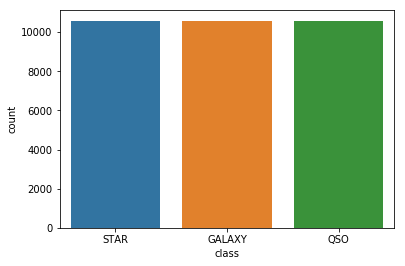

In [10]:
sns.countplot(x= 'class', data = df_resampling)
plt.show()

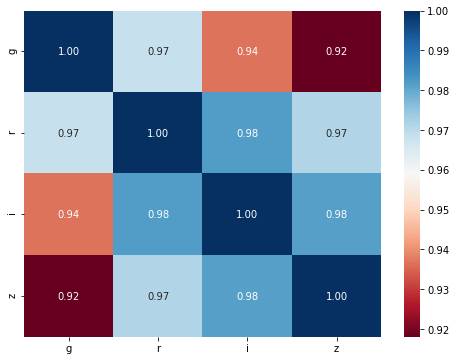

In [11]:
#Correlation
plt.figure(figsize=(8, 6))
df_corr = df_resampling.corr()
sns.heatmap(df_corr, annot=True, fmt='.2f', cmap='RdBu')
plt.show()

[]

<Figure size 576x576 with 0 Axes>

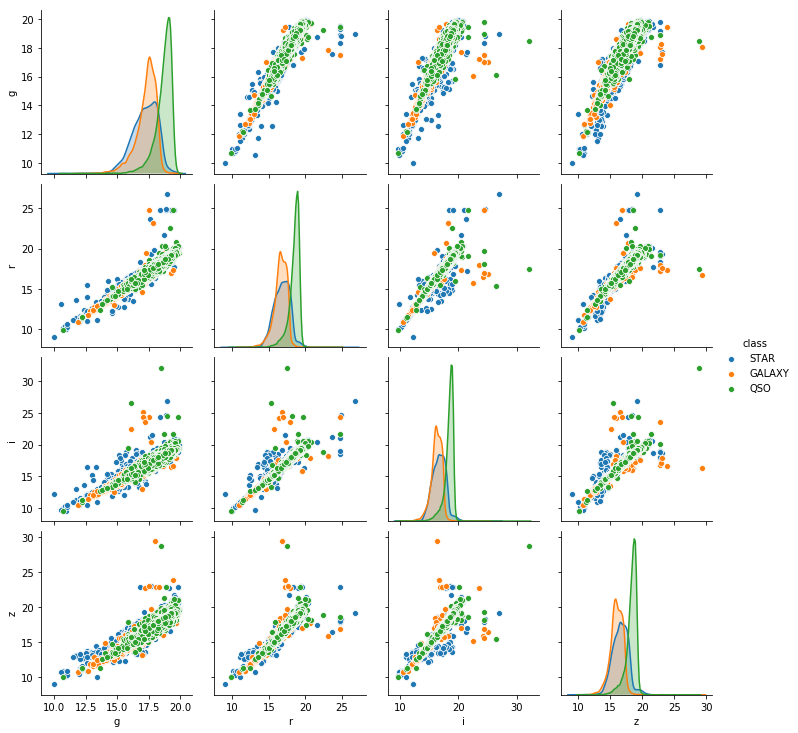

In [12]:
# Pairplot
plt.figure(figsize=(8, 8))
sns.pairplot(df_resampling, hue ="class")
plt.plot()

In [13]:
#Transform numpy array
X = df_resampling.iloc[:, :-1].to_numpy()
y = df_resampling['class'].to_numpy()
y = y.reshape(-1, 1)

In [14]:
# encode class values as integers
encoder = OneHotEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y).toarray()

In [15]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, encoded_Y, test_size=0.33)

In [16]:
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size = 0.25)

In [17]:
#Dependencies
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [18]:
# Neural network
model = Sequential()
model.add(Dense(32, input_dim=4, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001)

#Optimizer
adam = Adam(lr=1e-3, epsilon = 1e-8, beta_1 = .9, beta_2 = .999)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [20]:
history = model.fit(X_train, y_train,validation_data = (X_test,y_test), epochs=500, batch_size=64, 
                    callbacks= [reduce_lr])

Train on 21267 samples, validate on 7857 samples
Epoch 1/500
21267/21267 [==============================] - 3s 122us/step - loss: 1.0924 - accuracy: 0.3567 - val_loss: 1.0778 - val_accuracy: 0.3867
Epoch 2/500
21267/21267 [==============================] - 2s 73us/step - loss: 1.0024 - accuracy: 0.5395 - val_loss: 0.8852 - val_accuracy: 0.5851
Epoch 3/500
21267/21267 [==============================] - 2s 72us/step - loss: 0.7929 - accuracy: 0.6417 - val_loss: 0.7742 - val_accuracy: 0.6236
Epoch 4/500
21267/21267 [==============================] - 1s 70us/step - loss: 0.7614 - accuracy: 0.6677 - val_loss: 0.7547 - val_accuracy: 0.6538
Epoch 5/500
21267/21267 [==============================] - 2s 73us/step - loss: 0.7517 - accuracy: 0.6750 - val_loss: 0.7322 - val_accuracy: 0.7033
Epoch 6/500
21267/21267 [==============================] - 2s 76us/step - loss: 0.7332 - accuracy: 0.6859 - val_loss: 0.7151 - val_accuracy: 0.7136
Epoch 7/500
21267/21267 [==============================] - 2s 

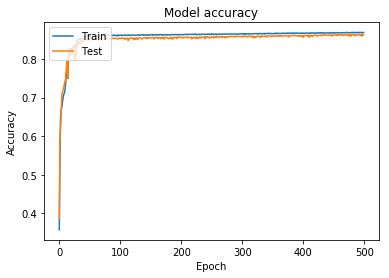

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

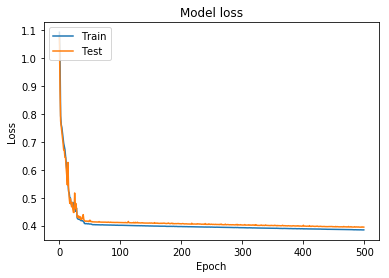

In [22]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

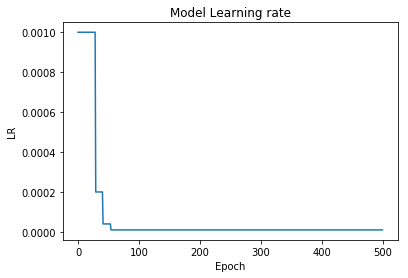

In [23]:
plt.plot(history.history['lr']) 
plt.title('Model Learning rate') 
plt.ylabel('LR') 
plt.xlabel('Epoch') 
plt.show()

In [24]:
y_prob = model.predict(X_val) 
y_classes = y_prob.argmax(axis=-1)
y_class = []
for i in range(len(y_classes)):
    y_class.append(encoder.categories_[0][y_classes[i]])
y_class = np.array(y_class)
result = encoder.transform(y_class.reshape(-1, 1)).toarray()

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:

fig= plt.figure(figsize=(8,6))

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

NameError: name 'confusion_matrix' is not defined

<Figure size 576x432 with 0 Axes>